In [1]:
# Import 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.04"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

# CLASIFICACION DE SEÑALES MEXART

&emsp; El clima espacial es un campo de estudio que busca entender y predecir las perturbaciones que el Sol genera en el entorno espacial de la Tierra. Estas perturbaciones pueden afectar el funcionamiento de satélites, sistemas de comunicación, navegación y energía eléctrica. Para monitorear el clima espacial se requiere de una red mundial de telescopios que observen las emisiones de radio del Sol y del medio interplanetario. En este artículo presentamos el proyecto MEXART, el primer radiotelescopio de su tipo en Latinoamérica, que forma parte de esta red mundial. El MEXART es un instrumento que capta señales de radio en una frecuencia de 140 MHz, utilizando un arreglo de 4096 antenas dipolo distribuidas en un área de 9500 metros cuadrados. El MEXART está ubicado en Coeneo, Michoacán, una región con condiciones favorables para la observación de radio. El MEXART permite estudiar el <a href="https://en.wikipedia.org/wiki/Interplanetary_scintillation">centelleo interplanetario</a>, un fenómeno que se produce cuando las ondas de radio atraviesan regiones turbulentas del plasma espacial. El MEXART es el resultado de una colaboración entre el Instituto de Geofísica de la UNAM, el Instituto Nacional de Astrofísica, Óptica y Electrónica, y otras instituciones nacionales e internacionales.

## 1 Introduccíon


### 1.1 El metodo de deteccion de centelleo interplanetario

&emsp; El método de detección de centelleo interplanetario (Interplanetary Scintillation, IPS) es una técnica utilizada en astronomía para estudiar la estructura y la dinámica del medio interplanetario. Su aplicación en la investigación espacial puede contribuir al conocimiento general sobre el entorno espacial y, por ende, mejorar la comprensión de eventos espaciales que podrían afectar a la Tierra.

#### 1.1.1 ¿Qué mide?

El IPS se utiliza para estudiar la ***variabilidad en la intensidad de las señales de radio*** es de radio extragalácticas. Este método se centra en los efectos de la ***refracción*** y ***dispersión*** causados por las irregularidades en la densidad del plasma en el medio interplanetario.

#### 1.1.2 ¿Cómo lo mide?
El IPS se basa en la observación de las fluctuaciones en la intensidad de las ondas de radio a medida que atraviesan el medio interplanetario. Estas fluctuaciones son causadas por las variaciones en la densidad del plasma solar y, por ende, en el ***índice de refracción***. Cuando las ondas de radio atraviesan estas regiones de plasma irregular, experimentan cambios en su velocidad y dirección, lo que se traduce en variaciones en la intensidad de la señal que llega a la Tierra.

Los telescopios de radio utilizados para la detección de centelleo interplanetario capturan estas variaciones y permiten a los astrónomos analizar la estructura del medio interplanetario.

#### 1.1.3 ¿Por qué es relevante?
Aunque el IPS en sí mismo no tiene un impacto directo en la prevención de problemas que afectan a la población, su aplicación en la investigación espacial es crucial para entender el medio interplanetario y los fenómenos solares. La comprensión de la variabilidad en la densidad del plasma en el espacio cercano a la Tierra es esencial para prever y mitigar eventos solares potencialmente perjudiciales.

Por ejemplo, el conocimiento detallado de la actividad solar y las condiciones en el medio interplanetario puede contribuir a la predicción de tormentas solares, permitiendo a los sistemas de energía y comunicación tomar medidas preventivas para evitar daños. Además, el estudio del IPS puede proporcionar información valiosa sobre la dinámica del viento solar y la interacción entre el Sol y el medio interplanetario, lo que contribuye a la comprensión de los procesos fundamentales en nuestro sistema solar.

# 2 Machine learning para la clasificacion de señales de IPS
Esta notebook tiene como objetivo desarrollar un método de clasificación de señales de centelleo interplanetarion del MEXART mediante el uso de machine learning con TensorFlow. El <a href="http://www.mexart.unam.mx/">MEXART</a> es un satélite de la Agencia Espacial Mexicana que se utiliza para estudiar la radiación cósmica y las partículas de alta energía en la atmósfera terrestre. El satélite recopila datos de señales de centelleo interestelar, que son señales de luz que se emiten cuando los rayos cósmicos interactúan con la atmósfera terrestre. Estas señales son muy débiles y difíciles de detectar, por lo que se necesita un método de clasificación preciso para analizarlas. La notebook utilizará TensorFlow, una plataforma de aprendizaje automático de extremo a extremo, para desarrollar un modelo de clasificación de señales de centelleo interestelar del MEXART. ¡Empecemos!

### 2.1 Preprocesamiento de datos:

En esta etapa, se deben preparar los datos para el modelado. Esto incluye la limpieza de datos, la selección de características y la normalización de datos.


#### 2.1.1 Creación de una función para leer los archivos del MEXART.

La base de datos que tenemos consta de alrededor de 6081 archivos de texto, distribuidos en 2962 directorios.
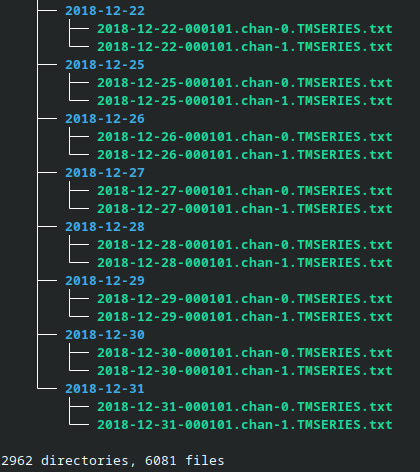

En cada directorio (que lleva el nombre del dia que se realizaron las mediciones) existen dos archivos de texto que contienen una serie de tiempo del las señales de radio. Una para cada canal. Ademas podemos observar que tienen unas lineas de cabezera. 

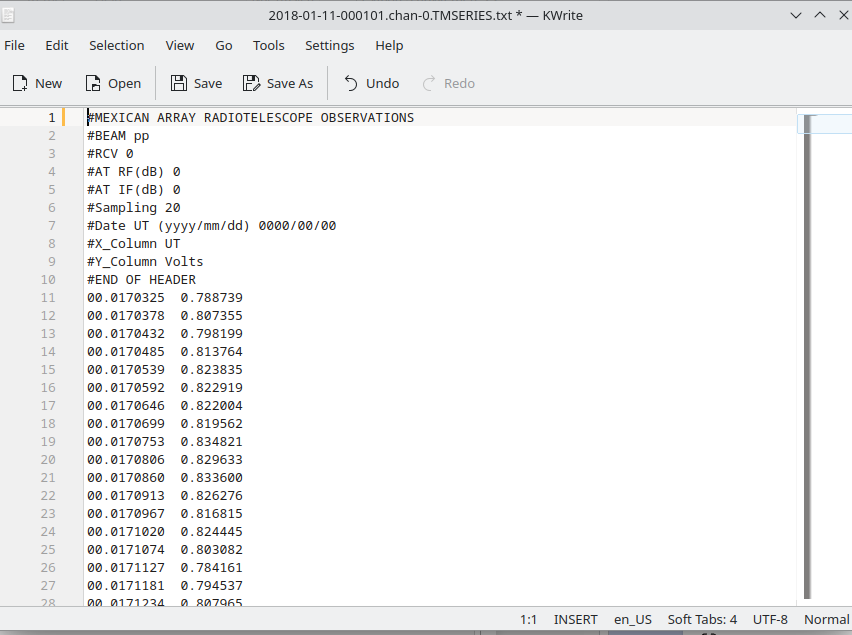

Al graficarla, obtenemos una serie de tiempo con una granularidad muy alta, pues la mayoria de los archivos contienen mas de 4.5 millones de mediciones para cada dia.


In [2]:
# Creacion de una lista con todos los archivos que estan descomprimidos

import os
import glob

directory = '/home/javier/Documentos/datos_MEXART'
txt_files = glob.glob(os.path.join(directory, '**/*.txt'), recursive=True)
print(f"Se econtraron {len(txt_files)} archivos de texto")

Se econtraron 6037 archivos de texto


In [3]:

def ReadTxtFiles(file):
    ### Function to load the time serieas from a txt file
    time = []    # empty list to get the time
    X = []       # empty list to get the voltages
    # Open the file in read mode
    with open(file, 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Ignore lines starting with "#" as they are comments
            if not line.startswith('#'):
                # Split the line into columns based on whitespace
                columns = line.split()
                # Extract data from the first and second columns
                time_value = float(columns[0])  # Assuming time values are floats
                X_value = float(columns[1])     # Assuming X values are floats
                # Append the values to their respective lists
                time.append(time_value)
                X.append(X_value)
    return [X,time]
            

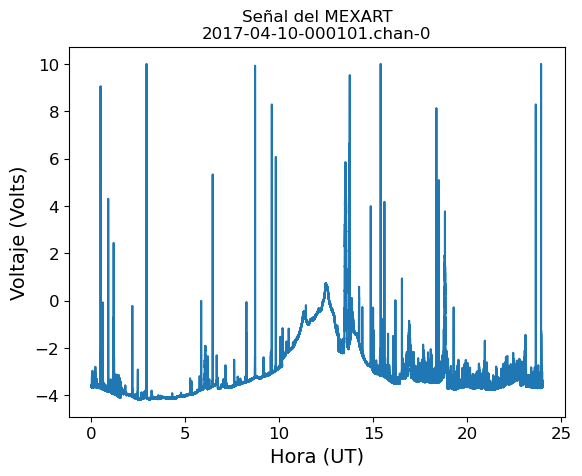

In [40]:
# Creacion de una grafica de una de las muestras de nuestros datos:
import matplotlib.pyplot as plt
import pandas as pd
import random
# Ruta de uno de los datos del mexart
file = txt_files[random.randint(0, len(txt_files))]

# Cargamos los datos en una lista
[X, t] = ReadTxtFiles(file)

# Create the plot
plt.plot(t, X)

# Add labels and title
plt.xlabel('Hora (UT)')
plt.ylabel('Voltaje (Volts)')
plt.title(f'Señal del MEXART\n{file[-37:-13]}')

# Show the plot
plt.show()

Cada una de estas gráficas consta de millones de mediciones. De cada una de estas series de tiempo, vamos a detectar todos los picos locales, los cuales de guardaran en un dataframe que sera pasado al conducto de <a href="https://es.wikipedia.org/wiki/Segmentaci%C3%B3n_(electr%C3%B3nica)">segmentacion</a> de preprocesamiento de datos. Pero antes, vamos a describir brevemente el algoritmo que detectara estos maximos locales.

### 2.2 Algoritmo de deteccion de picos.

Esta seccion es una traduccion de la documentacion de la libreria <a href="https://erdogant.github.io/findpeaks/pages/html/Topology.html">`findpeaks`</a>

#### 2.2.1 Topologia

El análisis topológico de datos (**TDA**) aplica métodos de topología en el análisis de datos y ha encontrado muchas aplicaciones en la ciencia de datos[<a href='https://www.sthu.org/research/talks/files/fhs-lunchtalk-nov2021-pershom.pdf'>1</a>]. TDA se basa en la observación de que los datos a menudo poseen una cierta forma intrínseca, como la forma de una nube de puntos, la forma de una señal o la forma de un objeto geométrico. La *Homología Persistente* (**HP**) es probablemente la herramienta más destacada del TDA que nos proporciona los medios para describir y cuantificar las propiedades topológicas de estas formas [<a href='https://www.sthu.org/blog/13-perstopology-peakdetection/index.html'>1</a>].

#### 2.2.2 Homología Persistente

En topología computacional, la idea de homología persistente conduce a una solución eficiente, rápida como ordenar números. No sólo detecta picos, sino que cuantifica la "importancia" de los picos de una forma natural que permite seleccionar los picos que son significativos para uno[<a href="https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/46680769#46680769">2</a>]. La idea de homología persistente es intuitiva: Consideremos el gráfico de la función que asigna a cada píxel su nivel. Su aspecto es el siguiente

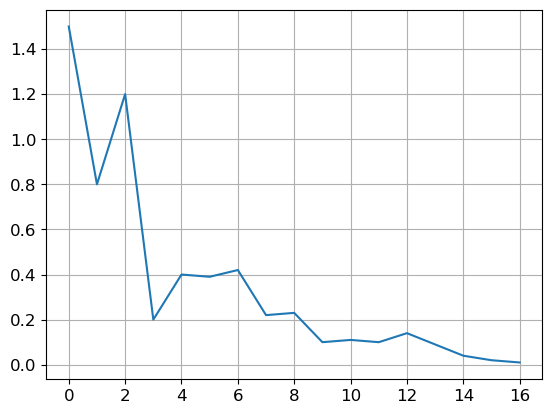

In [5]:
# Importamos la libreria de findpeaks
from findpeaks import findpeaks
# Initializamos la funcion de detecion de picos
fp = findpeaks(method='topology')
# Cargamos un vector ejemplo de 1-dimensión
X = fp.import_example('1dpeaks')
# Graficamos
plt.plot(X); plt.grid(True)

Consideremos ahora un nivel de agua que desciende continuamente a niveles inferiores. En los máximos locales surgen islas (***nacimiento***). En los puntos de ensilladura, dos islas se fusionan; consideramos que la isla inferior se fusiona con la isla superior (***muerte***). El llamado diagrama de persistencia (de las clases de homología de dimensión 0, nuestras islas) representa los valores de muerte sobre nacimiento de todas las islas:

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at None.


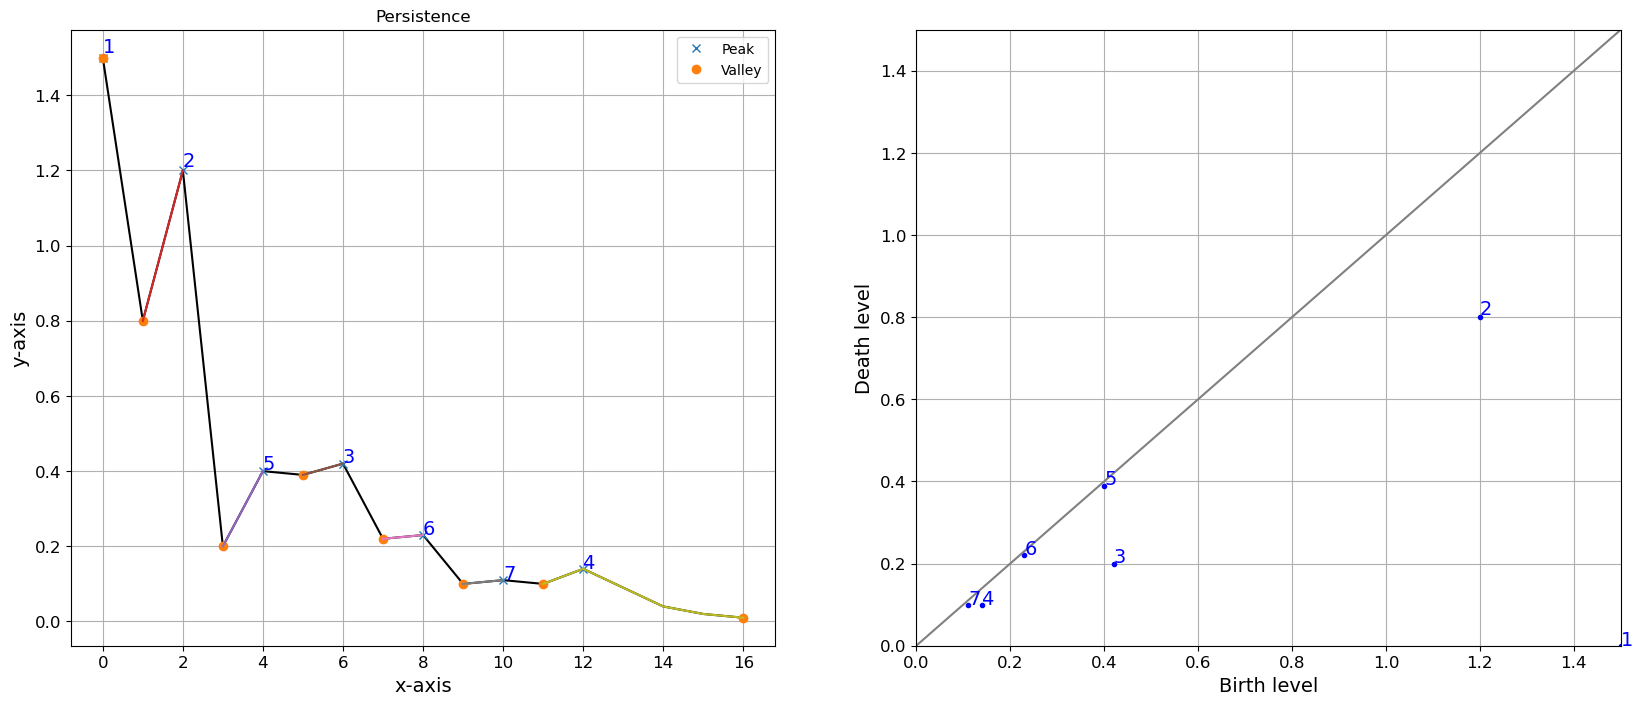

(<Axes: title={'center': 'Persistence'}, xlabel='x-axis', ylabel='y-axis'>,
 <Axes: xlabel='Birth level', ylabel='Death level'>)

In [6]:
# Aplicamos el algoritmo de persistencia homologica en el vector de ejemplo
results = fp.fit(X)
# graficamos los resultados
fp.plot_persistence()

La ***persistencia*** de una isla es entonces la diferencia entre el nivel de nacimiento y el nivel de muerte; la distancia vertical de un punto a la diagonal principal gris. La figura etiqueta las islas por persistencia decreciente. La figura de la derecha muestra las ubicaciones de los nacimientos de las islas. Este método no sólo da los máximos locales, sino que también cuantifica su "importancia" por la persistencia antes mencionada. De este modo, se filtrarían todas las islas con una persistencia demasiado baja, es decir, las situadas en la diagonal.

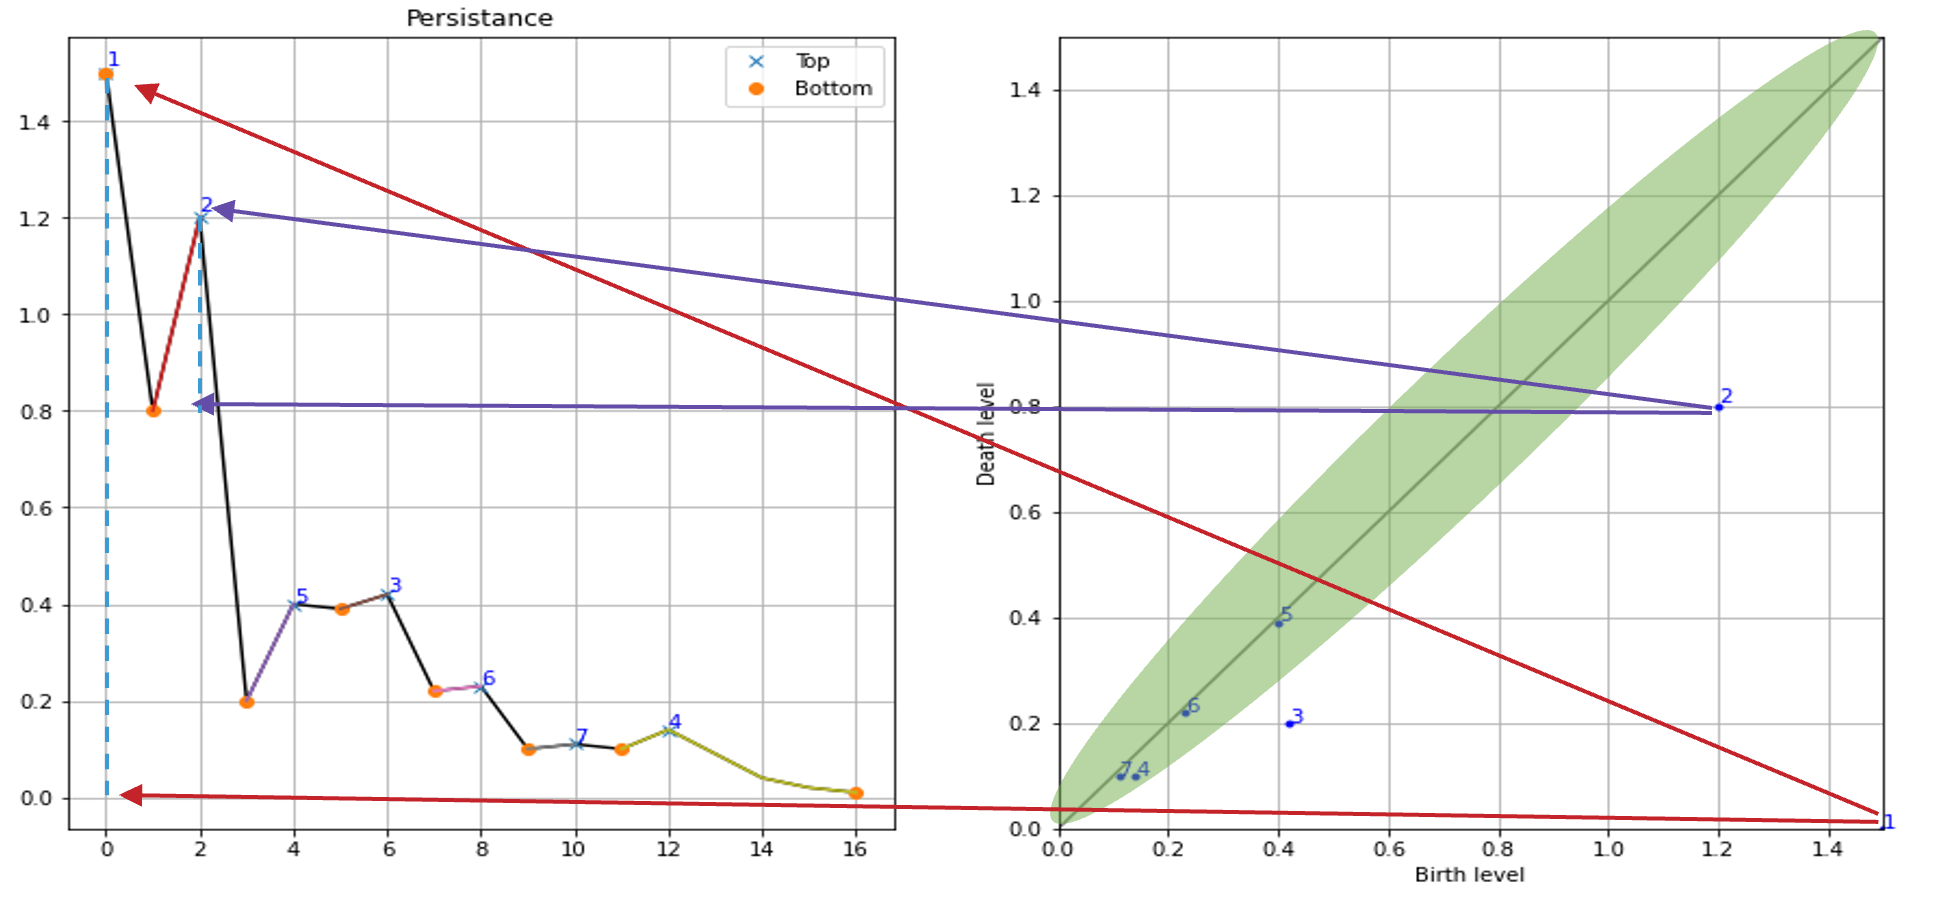

#### 2.2.3 Eficiencia

El método topológico está implementado de tal manera que se ejecuta en tiempo lineal -de hecho es un único bucle simple- después de ordenar los valores de las funciones. La complejidad temporal es $O(n \log n)$. Así que esta implementación debería ser facil y rápida en la práctica. La implementación original estaba en Python 2.7 [<a href="https://git.sthu.org/?p=persistence.git">4</a>], pero en `findpeaks` está (ligeramente) ajustada y reescrita para python 3.

#### 2.2.3.1 Uno-dimensional

La inicialización contiene muchas variables de las cuales sólo unas pocas son aplicables para el método de topología. Los parámetros generales son `figsize` y `verbose` que sirven para establecer el tamaño de la figura e imprimir mensajes en la pantalla. Específicamente para el método de topología, el método debe establecerse en "`topology`", y además, los parámetros `interpolate` y `limit` pueden utilizarse para algunos ajustes de preprocesamiento y salida. Por defecto, no se aplica interpolación y no hay límite en los resultados finales. Vea aquí los detalles <a href="https://erdogant.github.io/findpeaks/pages/html/findpeaks.findpeaks.html#findpeaks.findpeaks.findpeaks">`findpeaks.findpeaks.findpeaks()`</a>

In [7]:
# Importamos la libreria
from findpeaks import findpeaks
# Initializamos
fp = findpeaks(method='topology', interpolate=None, limit=None, figsize=(15, 8), verbose=3)
# Fit topology method on the 1d-vector
results = fp.fit(X)
# The output contains multiple variables
print(results.keys())
# dict_keys(['persistence', 'Xdetect', 'Xranked', 'groups0', 'df'])

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at None.
dict_keys(['persistence', 'Xdetect', 'Xranked', 'groups0', 'df'])


La salida es un diccionario que contiene múltiples variables que pueden ser de utilidad para el análisis posterior. Véase: <a href="https://erdogant.github.io/findpeaks/pages/html/findpeaks.findpeaks.html#findpeaks.findpeaks.findpeaks.peaks1d">findpeaks.findpeaks.findpeaks.peaks1d()</a> Tenga en cuenta que este DataFrame NO se filtra en la variable límite, ya que debe estar en consonancia con el conjunto de datos de entrada.


<dt>Para la persistencia homologica, el dataframe <code>persistence</code> contiene:</dt><dd><ul class="simple">
    <li><p>x, y    : coordenadas</p></li>
    <li><p>birth   : Nivel de nacimiento</p></li>
    <li><p>death   : Nivel de muerte</p></li>
    <li><p>score   : Score de persistencia</p></li>
</ul>
</dd>


In [8]:
# Print results to screen
results['df']

,x,y,labx,rank,score,valley,peak
0,0,1.50,1.0,1,1.50,True,True
1,1,0.80,2.0,0,0.00,True,False
2,2,1.20,2.0,2,0.40,False,True
3,3,0.20,3.0,0,0.00,True,False
4,4,0.40,3.0,5,0.01,False,True
5,5,0.39,4.0,0,0.00,True,False
6,6,0.42,4.0,3,0.22,False,True
7,7,0.22,5.0,0,0.00,True,False
8,8,0.23,5.0,6,0.01,False,True
9,9,0.10,6.0,0,0.00,True,False


In [9]:
results['persistence']

,x,y,birth_level,death_level,score
0,0,0,1.50,0.00,1.50
1,0,2,1.20,0.80,0.40
2,0,6,0.42,0.20,0.22
3,0,12,0.14,0.10,0.04
4,0,4,0.40,0.39,0.01
5,0,8,0.23,0.22,0.01
6,0,10,0.11,0.10,0.01


El parámetro de entrada `limit` filtrará los resultados basándose en la puntuación del `score`, y mantendrá sólo aquellos con `score`>`limit`. La limitación resulta muy útil cuando los datos son ruidosos y se detectan muchos picos a lo largo de la diagonal. Fijemos el límite en `limit=0,0101` y comprobemos los resultados:

In [10]:
fp = findpeaks(method='topology', interpolate=None, limit=0.0101, verbose=5)
results = fp.fit(X)
# Print results to screen
results['persistence']

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at 0.0101.


34it [00:00, 46618.61it/s]


,x,y,birth_level,death_level,score
0,0,0,1.50,0.0,1.50
1,0,2,1.20,0.8,0.40
2,0,6,0.42,0.2,0.22
3,0,12,0.14,0.1,0.04


El parámetro de entrada "`interpolate`" extiende los datos por este factor y sirve para "suavizar" la señal mediante una interpolación lineal. Una señal suavizada puede ser más robusta frente al ruido y ofrecer mejores resultados en la detección de picos y valles. Este paso puede considerarse una etapa de preprocesamiento antes de aplicar cualquier método. Los resultados se basan en los datos interpolados y se remiten a los datos de entrada originales. En este caso, los resultados son muy similares a los obtenidos sin interpolación. Sin embargo, las puntuaciones de persistencia son ligeramente diferentes.

Veámoslo con un ejemplo:

In [11]:
# Import library
from findpeaks import findpeaks
# Initialize with interpolation
fp = findpeaks(method='topology', interpolate=10, limit=None)
# Fit topology method on the interpolated 1d-vector
results = fp.fit(X)
# The results for the interpolated data.
results['persistence']

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Interpolating 1d-vector by factor 10
[findpeaks] >Detect peaks using topology method with limit at None.


,x,y,birth_level,death_level,score
0,0,0,1.500000,0.000000,1.500000
1,0,19,1.229994,0.800000,0.429994
2,0,60,0.433313,0.124612,0.308701
3,0,126,0.140000,0.091063,0.048937
4,0,45,0.431017,0.390000,0.041017
5,0,82,0.233771,0.203954,0.029817
6,0,106,0.110521,0.097933,0.012588


### 2.3 Seleccion de parametros de los datos del MEXART

Vamos a utilizar la libreria de `findpeaks` para generar un dataframe de cada archivo de texto a nuestra dispocision. Este contendra los parametros que usaremos para clasificar las señales. 

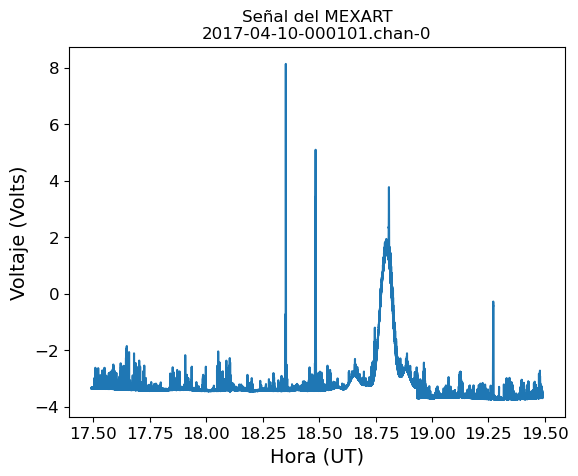

In [41]:
# Import library
from findpeaks import findpeaks
from math import floor
import matplotlib.pyplot as plt

# Example 1d-vector
cenit = 18.5
w = 1
i = cenit-w
f = cenit+w
[X, t] = ReadTxtFiles(file)


# Plot the sample
plt.plot(t[floor(len(X)*i/24):floor(len(X)*f/24)],X[floor(len(X)*i/24):floor(len(X)*f/24)])

# Add labels and title
plt.xlabel('Hora (UT)')
plt.ylabel('Voltaje (Volts)')
plt.title(f'Señal del MEXART\n{file[-37:-13]}')

# Show the plot
plt.show()

Aqui estamos graficando solamente el intervalo de tiempo que contiene las señales de cuando el sol esta en cenit en la ubicacion del MEXART.


Vamos a hacer algunos histogramas de los datos que tenemos para escoger algunos parametros de clasficacion. Algunas observaciones que podemos hacer sobre las distribuciones son:

- **Tamaño equilibrado de los clusters**

- **Varianza similar**

- **Modos identificables**

- **Ruido mínimo**

- **Consideración de valores atípicos**

- **Evaluación de la asimetría y la curtosis**

Comenzemos con el histrograma de las amplitudes de las señales:

The kurtosis of the histogram is 10.886163736330833
The skewness of the dataset is 2.566206462011534


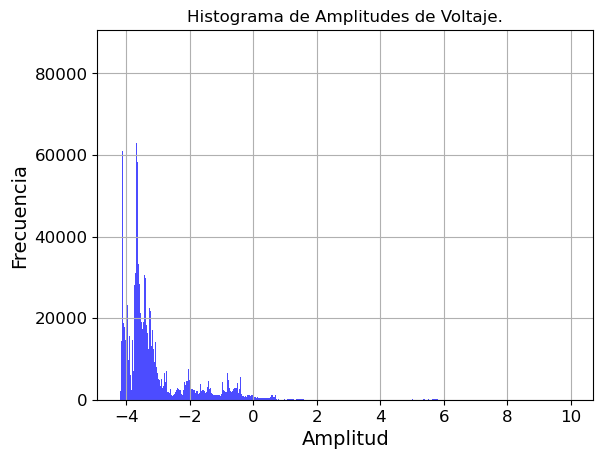

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew


# Calculate the kurtosis and skewness
kurt = kurtosis(X)
skewness = skew(X)

# Print the kurtosis
print(f"The kurtosis of the histogram is {kurt}")
print(f"The skewness of the dataset is {skewness}")

plt.hist(X, bins=2000, color='blue', alpha=0.7)
plt.title('Histograma de Amplitudes de Voltaje.')
plt.xlabel('Amplitud')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

- **Tamaño equilibrado de los clusters**: Los clusters notables a simple vista tienen una reprecentacion en el mismo orden de magnitud ($10^5$).

- **Varianza similar**: Es beneficioso que los clusters tengan una varianza similar. Esto asegura que k-means trate a cada cluster por igual y no favorezca a los clusters con mayores varianzas. En este caso parece ser que se cumple.

- **Modos identificables**: Modos o picos claramente identificables en el histograma pueden sugerir la presencia de clusters distintos. En este caso vemos que si es posible ver los picos a simple vista.

- **Ruido mínimo**: Lo ideal sería que el histograma estuviera relativamente libre de ruido o valores atípicos que pudieran interferir en el proceso de agrupación. Desconocemos las caracteristicas de el ruido en estas señales.

- **Consideración de valores atípicos**: Si hay valores atípicos, es conveniente tratarlos adecuadamente, ya que k-means es sensible a los valores atípicos. En este caso podemos ver que alrededor de 7.5 V existe una isla de valores atipicos.

- **Evaluación de la asimetría y la curtosis**: Aunque k-means no asume la normalidad, la comprensión de la asimetría y la curtosis puede proporcionar información sobre la forma de la distribución. En este caso la curtosis es positiva y de 4.9, por lo que no es una distribucion normal.

Ahora veamos que pasa con la velocidad de cambio de estas amplitudes:

The kurtosis of the histogram is 5279.054224116797
The skewness of the dataset is -3.1562728520798915


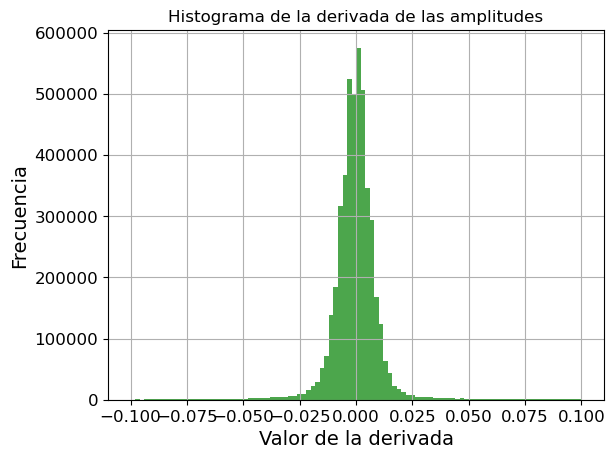

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the derivative of the time series
derivative_series = np.diff(X)

# Calculate the kurtosis and skewness
kurt = kurtosis(derivative_series)
skewness = skew(derivative_series)

# Print the kurtosis
print(f"The kurtosis of the histogram is {kurt}")
print(f"The skewness of the dataset is {skewness}")

# Plot the derivative histogram
plt.hist(derivative_series, bins=100, color='green', alpha=0.7,range=(-.1,.1))
plt.title('Histograma de la derivada de las amplitudes')
plt.xlabel('Valor de la derivada')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Ahora veamos el histrograma de la persistencia de los picos para uno de los dias.

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at 0.475.
Elapsed time: 17.769636869430542 seconds


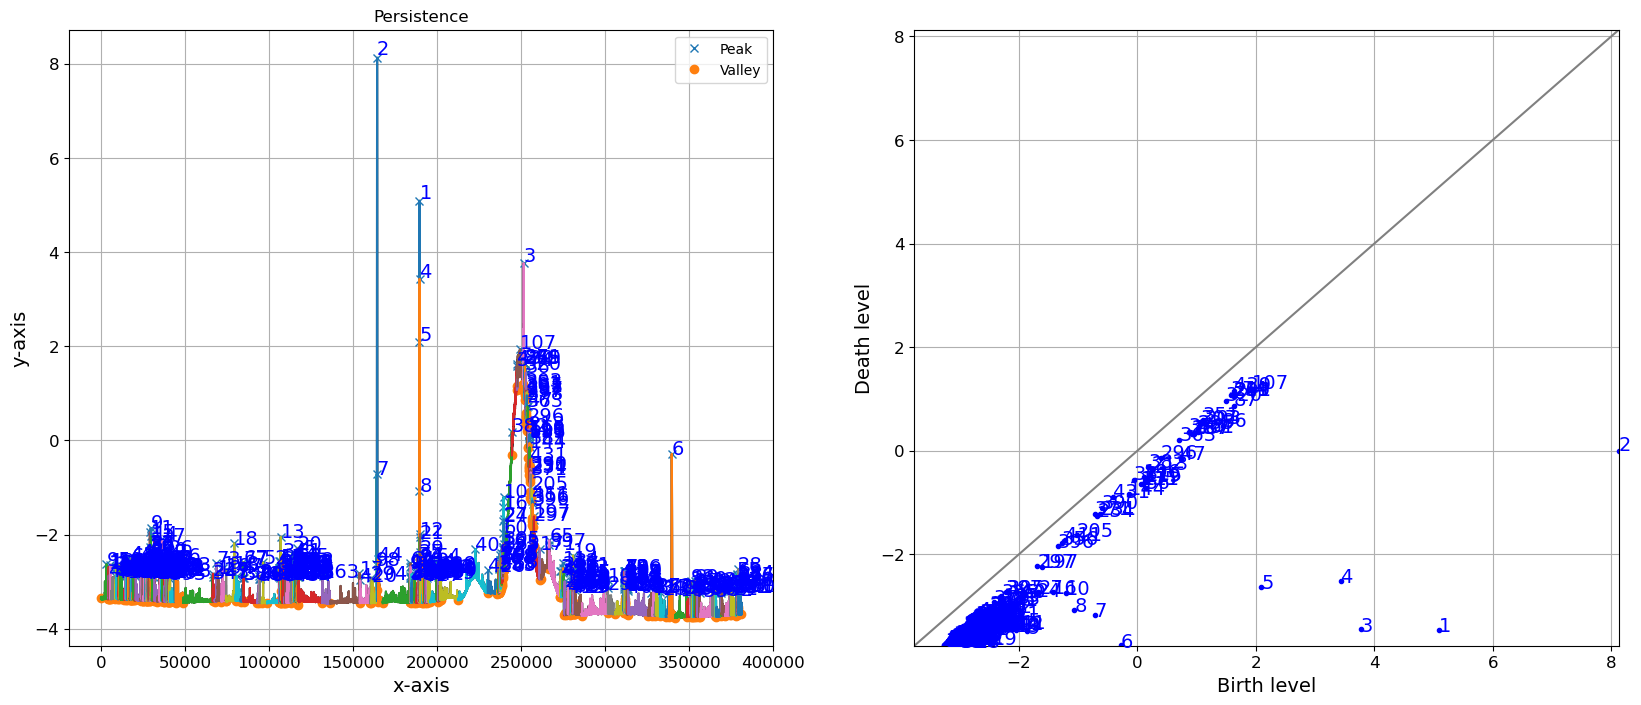

(<Axes: title={'center': 'Persistence'}, xlabel='x-axis', ylabel='y-axis'>,
 <Axes: xlabel='Birth level', ylabel='Death level'>)

In [44]:
from findpeaks import findpeaks
import time

start_time = time.time()

# Initialize
fp = findpeaks(method='topology', limit=0.475)
#fp = findpeaks(method='peakdetect', lookahead=300, interpolate=None)


# Fit topology method on the 1d-vector
results = fp.fit(X[floor(len(X)*i/24):floor(len(X)*f/24)])

end_time = time.time()

print("Elapsed time:", end_time - start_time, "seconds")

# Plot
fp.plot_persistence()




The kurtosis of the histogram is 12446.3042850163
The skewness of the dataset is 7.692534633771381e-18


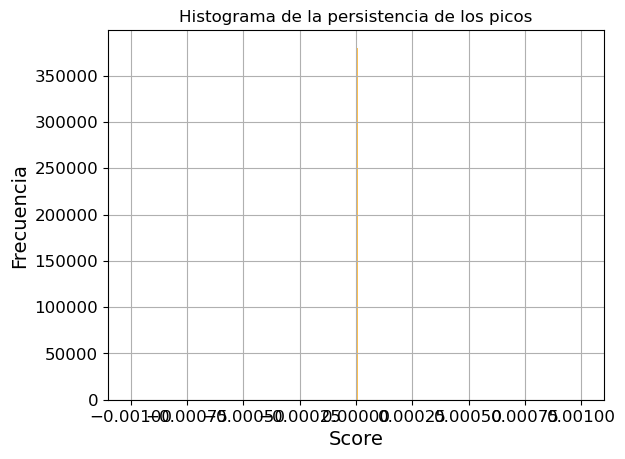

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the derivative of the time series
data = np.diff(results['df']['score'])

# Calculate the kurtosis and skewness
kurt = kurtosis(data)
skewness = skew(data)

# Print the kurtosis
print(f"The kurtosis of the histogram is {kurt}")
print(f"The skewness of the dataset is {skewness}")

# Plot the derivative histogram
plt.hist(data, bins=200, color='orange', alpha=0.7)
plt.title('Histograma de la persistencia de los picos')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

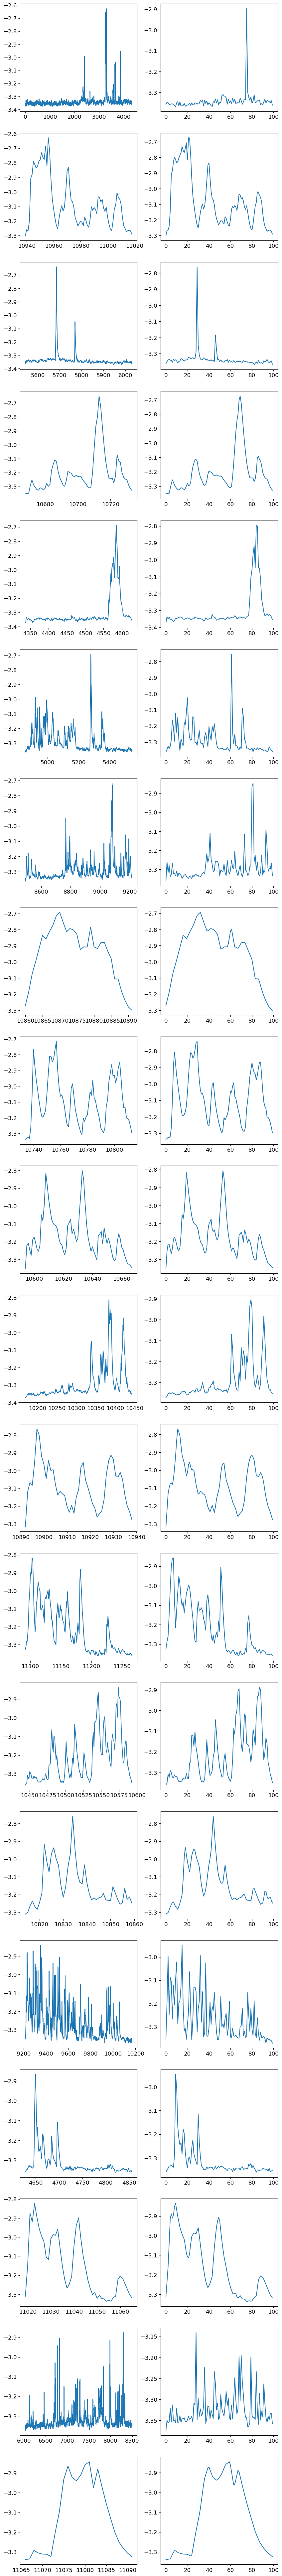

In [49]:
df = results['df']

# Dictionary of the shapes of the peaks
y_dict = dict(tuple(df.groupby('labx')['y']))

max_peaks = results['df'][results['df']['peak']==True].head(20).sort_values('rank')['labx'].tolist()

N = len(max_peaks) # Number of Subplots

# Create a figure with subplots
fig, axs = plt.subplots(nrows=N, ncols=2,figsize=(10,100))

i=0
for peak in max_peaks:
    # Generate some random time series data
    data = y_dict[peak]

    # Subsample the data to 10 points
    subsampled_data = np.interp(np.linspace(0, len(data) - 1, 100), np.arange(len(data)), data)

    # Plot the data on the subplots
    axs[i,0].plot(data)
    axs[i,1].plot(subsampled_data)
    i +=1


In [47]:
results['df'][results['df']['peak']==True].sort_values('rank')

,x,y,labx,rank,score,valley,peak
189502,189502,5.091478,229.0,1,8.549630,False,True
164269,164269,8.130465,209.0,2,8.130465,False,True
251486,251486,3.768215,285.0,3,7.219958,False,True
189554,189554,3.434653,230.0,4,5.955291,False,True
189449,189449,2.095827,228.0,5,4.732128,False,True
...,...,...,...,...,...,...,...
351162,351162,-3.270771,406.0,435,0.477913,False,True
350756,350756,-3.177081,403.0,436,0.477607,False,True
116559,116559,-2.877089,190.0,437,0.477302,False,True
237699,237699,-2.672618,267.0,438,0.476386,False,True


# División de datos: 
Los datos se dividen en conjuntos de entrenamiento y prueba. El conjunto de entrenamiento se utiliza para entrenar el modelo, mientras que el conjunto de prueba se utiliza para evaluar el rendimiento del modelo.


# Creación del modelo: 
Se crea un modelo de clasificación utilizando TensorFlow. El modelo se entrena utilizando el conjunto de entrenamiento.


# Validación del modelo: 
Se evalúa el rendimiento del modelo utilizando el conjunto de prueba. Se ajustan los parámetros del modelo para mejorar su rendimiento.

# Predicción: 
Se utiliza el modelo entrenado para predecir la clase de una nueva serie de tiempo.


# Creación de un diccionario de clasificación: 
Se crea un diccionario que asocia la serie de tiempo con la clase predicha.